---
# QC notebook for Gridmet mapping to onhm HRUs (GF_v11)

* Gridmet only provides a partial mapping to the full GF_v11.  In this notebook the HRUs with 1) no-mapping 2) partial-mapping, and 3) full-mapping will be identified.  For those HRUs that are fully mapped by the Gridmet data a confimation that the weights sum to 1 will be provided.  A file will be generated that indicates the hru_ids (In this case nhru_v11) for 1) partial-mapped hrus and 2) no-mapped hrus.   Finally a plot of the raw data and mapped data for tmax will be provided as a qualitative confirmation of the mapping.

In [1]:
import onhm
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

---

Load paths and files on denali


---

In [2]:
from pathlib import Path

p_gm = Path('/caldera/projects/usgs/water/wbeep/onhm_dev/climate/gm_gf_v11')
p_gmr = Path('/caldera/projects/usgs/water/wbeep/onhm_dev/climate/gridmet_raw')
#I put the gf_v11 shapefile, only hru polys, in the following folder for processing so we'll use it for plotting
shpf_p = Path('/caldera/projects/usgs/water/wbeep/onhm_dev/climate/gridmet_raw')
# weights file used to map gridded gridmet to hrus is here
gm_wght_f = Path('/caldera/projects/usgs/water/wbeep/onhm_dev/climate/git/onhm-fetcher-parser/') / 'tmp_Gridmet_weights_hru_v1_1e.csv'
print(f'the path {p_gm} exits: ', p_gm.exists())
print(f'the path {p_gmr} exits: ', p_gmr.exists())
print(f'the path {shpf_p} exits: ', shpf_p.exists())
print(f'the file {gm_wght_f} exits: ', gm_wght_f.exists())

the path /caldera/projects/usgs/water/wbeep/onhm_dev/climate/gm_gf_v11 exits:  True
the path /caldera/projects/usgs/water/wbeep/onhm_dev/climate/gridmet_raw exits:  True
the path /caldera/projects/usgs/water/wbeep/onhm_dev/climate/gridmet_raw exits:  True
the file /caldera/projects/usgs/water/wbeep/onhm_dev/climate/git/onhm-fetcher-parser/tmp_Gridmet_weights_hru_v1_1e.csv exits:  True


---

Read the GF_v11 shapefile (in geographic projection) into geopandas dataframe

---

In [3]:
shapefiles = shpf_p.glob("*2e*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)
# gdf.plot()
print(gdf)

               LAYER            GM_TYPE  OBJECTID  nhru_v11  hru_segme1  \
0       NHM\nhru_v11  Unknown Area Type         1     76127       40038   
1       NHM\nhru_v11  Unknown Area Type         2     76147       40038   
2       NHM\nhru_v11  Unknown Area Type         3     76170       40021   
3       NHM\nhru_v11  Unknown Area Type         3     76170       40021   
4       NHM\nhru_v11  Unknown Area Type         3     76170       40021   
...              ...                ...       ...       ...         ...   
139802  NHM\nhru_v11  Unknown Area Type    114954     57964       31028   
139803  NHM\nhru_v11  Unknown Area Type    114955     64080       28886   
139804  NHM\nhru_v11  Unknown Area Type    114956     64150       28866   
139805  NHM\nhru_v11  Unknown Area Type    114957     65633       31412   
139806  NHM\nhru_v11  Unknown Area Type    114958     18843       10081   

        Shape_Leng Shape_Area  nhm_id  hru_id_nat  Version  \
0        92601.509  188151328   76128

---

The next cells look at the weights file used to map gridded gridmet data to the HRU polygons.  Gridmet is available for conus only.  There are HRUs in GF_v11_2e that are either entirely outside the Gridmet footprint or are partially in the Gridmet footprint.  

---

In [4]:
pd_wght_f = pd.read_csv(gm_wght_f)
wghts_id = pd_wght_f.columns[1]
print(f'wght_id: {wghts_id}')
pd_wght_f.head()

wght_id: nhru_v11


,grid_ids,nhru_v11,w
0,638227,76127,0.030892
1,638228,76127,0.011476
2,638226,76127,0.094655
3,638225,76127,0.095469
4,636842,76127,0.017072


---

Group the weights file by nhru_v11 (the hru id) and sum the weights

---

In [5]:
wght_sum = pd_wght_f.groupby(wghts_id).sum()
wght_sum.head()


,grid_ids,w
nhru_v11,,
1,1385235,1.000000
2,1105414,1.000000
3,275660,1.000000
4,551321,0.999999
5,1106812,1.000000


In [6]:
wght_sum.index.values

array([     1,      2,      3, ..., 114956, 114957, 114958])

---

By the nature of the algorithm to generate the weights file, those HRUs outside of conus are not included in the weights file.  However those HRUs with partial area within the Gridmet footprint with have wieghts that sum to less than 1

___

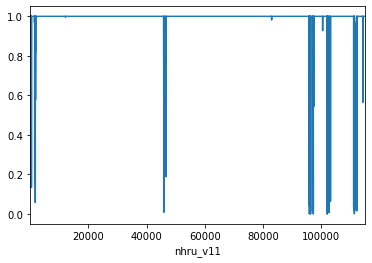

In [7]:
wght_sum.w.plot()
ax = plt.gca()
ax.ticklabel_format(useOffset=False)

___

Gather the HRU weights that sum to less than 1.  These are the HRUs partially filled by Gridmet and print to file GM_Partial_HRUs.txt

___

In [8]:
oc_hru = wght_sum.loc[wght_sum['w'] < 0.999999]
print(oc_hru.head())
tmp = oc_hru.index.values.astype(int)
np.set_printoptions(suppress=True)
np.savetxt('GM_Partial_HRUs.txt', tmp, fmt='%6d')

          grid_ids         w
nhru_v11                    
175        3438552  0.927611
213        1519020  0.202471
268        2503058  0.449901
310        1011362  0.999999
315         557163  0.302366


---
Gather HRUs that are completely outside of the Gridmet footprint.  These will be HRUs that have no weights.  Print to file GM_NoWeight_HRUs.txt

---

In [9]:
# gather the HRUs that have partial weights
oc1_gdf = gdf[gdf['nhru_v11'].isin(oc_hru.index.values)]
oc1_gdf.loc[:,'hru_type'] = 0
# print(oc1_gdf.head())

# gather the HRUs that are have no wieghts
oc2_gdf = gdf[~gdf['nhru_v11'].isin(wght_sum.index.values)]
oc2_gdf.loc[:,'hru_type'] = 1
# print(oc2_gdf.head())
# write the hru-ids that have no wieghts to a file
np.savetxt('GM_NoWieght_HRUs.txt', oc2_gdf['nhru_v11'].values, fmt='%6d')

# gather the HRUs that are completely in the Gridmet footprint
ic_gdf = gdf[gdf['nhru_v11'].isin(wght_sum.index.values)]
ic_gdf.loc[:,'hru_type'] = 2
# print(ic_gdf.head())


/home/rmcd/miniconda3/envs/ofp_env/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/rmcd/miniconda3/envs/ofp_env/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


---

Plot the 3 different catagories of mapped values
---

Text(0.5, 1, 'Gridmet')

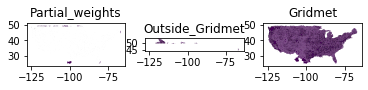

In [10]:
fig, ax = plt.subplots(1,3)
oc1_gdf.plot(column='hru_type', ax=ax[0])
ax[0].set_title('Partial_weights')
oc2_gdf.plot(column='hru_type', ax=ax[1])
ax[1].set_title('Outside_Gridmet')
ic_gdf.plot(column='hru_type', ax=ax[2])
ax[2].set_title('Gridmet')

---

Different mapping

I modified the following example to generate a catagorical color table for the plot below:
https://towardsdatascience.com/create-categorical-choropleth-with-python-122da5ae6764

---

In [11]:
full_gdf = pd.concat([oc1_gdf, oc2_gdf, ic_gdf])

In [12]:
from matplotlib import cm
# Prepare the colors
keys = list(full_gdf['hru_type'].unique())
color_range = list(np.linspace(0, 1, len(keys), endpoint=False))
colors = [cm.tab20c(x) for x in color_range]
color_dict = dict(zip(keys, colors))
color_dict['Gridmet'] = 'lightgray'

color_dict[0]
# full_gdf.plot(column='hru_type', legend=True)

(0.19215686274509805, 0.5098039215686274, 0.7411764705882353, 1.0)

([<matplotlib.patches.Wedge at 0x7fffa0d80e10>],
 [Text(-0.44000000000000006, 5.388445916248355e-17, 'Gridmet')])

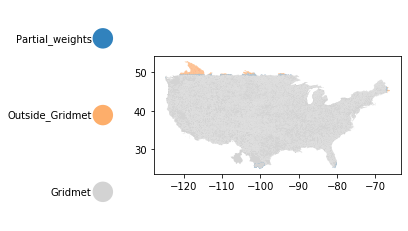

In [13]:
# Prepare the grid
row_count = full_gdf['hru_type'].nunique()
ax_list = []
for i in range(row_count+1):
    ax_list.append('ax' + str(i+1))
    ax_string = ', '.join(ax_list)
    
fig, (ax_string) = plt.subplots(row_count, 4)
ax1 = plt.subplot2grid((row_count,4), (0,1), rowspan=row_count, colspan=3)
oc1_gdf.plot(color=color_dict[0], ax=ax1)
oc2_gdf.plot(color=color_dict[1], ax=ax1)
ic_gdf.plot(color=color_dict['Gridmet'], ax=ax1)

plt.subplot2grid((row_count,4),(0,0))
plt.pie([1], labels=['Partial_weights'], radius=0.4, colors=[color_dict[0]])

plt.subplot2grid((row_count,4),(1,0))
plt.pie([1], labels=['Outside_Gridmet'], radius=0.4, colors=[color_dict[1]])

plt.subplot2grid((row_count,4),(2,0))
plt.pie([1], labels=['Gridmet'], radius=0.4, colors=[color_dict['Gridmet']])

---
# plot sum of weights for all HRUs that are fully mapped

---

In [14]:
ic_whts = wght_sum[wght_sum.index.isin(gdf['nhru_v11'].values) & ~wght_sum.index.isin(oc_hru.index.values)]


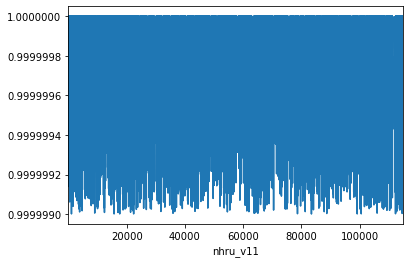

In [15]:
ic_whts.w.plot()
ax = plt.gca()
ax.ticklabel_format(useOffset=False)

---
# Plot example day from the Raw Gridmet data and the HRU-Mapped data

---

Pull the an example file for tmax from the raw gridmet data

In [16]:
ftmax = list(p_gmr.glob('2018_gm_tmax*.nc'))

In [17]:
dtmax = xr.open_dataset(ftmax[0])
dtmax

<xarray.Dataset>
Dimensions:                    (day: 365, lat: 585, lon: 1386)
Coordinates:
  * day                        (day) datetime64[ns] 2018-01-01 ... 2018-12-31
  * lat                        (lat) float64 49.4 49.36 49.32 ... 25.11 25.07
  * lon                        (lon) float64 -124.8 -124.7 ... -67.1 -67.06
Data variables:
    daily_maximum_temperature  (day, lat, lon) float32 ...
Attributes:
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.0
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.400000000000006
    geospatial_lon_min:         -124.76666663333334
    geospatial_lon_max:         -67.05833330000002
    geospatial_lon_resolution:  0.041666666666666
    geospatial_lat_resolution:  0.041666666666666
    geospatial_lat_units:       decimal_degrees north
    geospatial_lon_units:       decimal_degrees east
    coordinate_system:          EPSG:4326
    author:                     John Abatzoglou - University of Idaho, jabatz...
    date:                       02 March 2020
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...
    History:                    Translated to CF-1.0 Conventions by Netcdf-Ja...

In [18]:
# import datetime as dt
# date = dt.datetime(year=int(1980),month=1,day=1)
# try:
#     lon = dprcp.lon.values
#     lat = dprcp.lat.values
#     ndata = np.zeros((1, (np.shape(lon)[0]) * (np.shape(lat)[0])))
#     ndata[0,:] = dprcp.daily_maximum_temperature  .sel(day=date).values.flatten()
# except KeyError:
#     print('error')

Open a hru-mapped dataset for tmax

In [19]:
ds = xr.open_dataset(p_gm / 'gm_climate_2018.nc' )
ds

<xarray.Dataset>
Dimensions:  (hruid: 114958, time: 365)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * hruid    (hruid) int32 1 2 3 4 5 6 ... 114954 114955 114956 114957 114958
Data variables:
    hru_lat  (hruid) float32 ...
    hru_lon  (hruid) float32 ...
    prcp     (time, hruid) float32 ...
    tmax     (time, hruid) float32 ...
    tmin     (time, hruid) float32 ...
    rhmax    (time, hruid) float32 ...
    rhmin    (time, hruid) float32 ...
    ws       (time, hruid) float32 ...
Attributes:
    Conventions:  CF-1.8
    featureType:  timeSeries
    history:

---
Grab values from hru-mapped dataset (ds) and map to the geodatafram (gdf) for plotting

---

In [20]:
gdf['tmax'] = 0.0
for index, row in gdf.iterrows():
    hind = row['nhru_v11']
    value = ds.tmax.values[0,hind-1]
    gdf.at[index,'tmax'] = ds.tmax.values[0,hind-1]
        

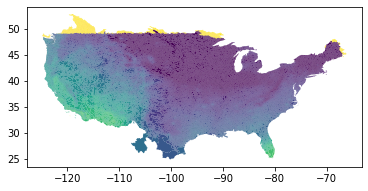

In [21]:
gdf.plot(column='tmax',vmin=-13, vmax=40)

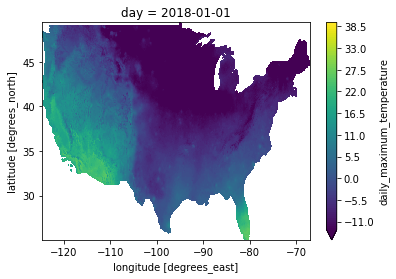

In [22]:
import datetime as dt
lvls = np.arange(-13, 40, 0.5)
date = dt.datetime(year=2018,month=1,day=1)
xrtmax = dtmax.daily_maximum_temperature.sel(day=date)-273.5
xrtmax.plot(levels=lvls, cmap='viridis')

In [43]:
dsr.daily_maximum_temperature.sel(day=date).values.flatten()

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)